In [1]:
#pip install holidays

In [2]:
# Basic imports
import numpy as np
import pandas as pd
import datetime # manipulating date formats
import itertools
import time
import holidays
import os

from math import sqrt
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as MAPE
from sklearn import datasets, linear_model

# Stats packages
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [3]:
atl_v = pd.read_csv("/Users/sameshbajaj/Desktop/Time Series Analysis/Assignments/Project/nyc_violent_final copy.csv", parse_dates=['date'])
atl_temp = pd.read_csv("/Users/sameshbajaj/Desktop/Time Series Analysis/Assignments/Project/ISYE6203_ATL_avg_temp_2009-2020.csv", parse_dates=['date'])
holiday = pd.read_csv("/Users/sameshbajaj/Desktop/Time Series Analysis/Assignments/Project/Holidays_2009-2020.csv", parse_dates=['date'])

In [4]:
atl_v = atl_v.set_index("date")
atl_temp = atl_temp.set_index("date")
holiday = holiday.set_index("date")

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

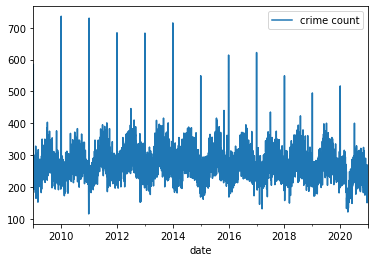

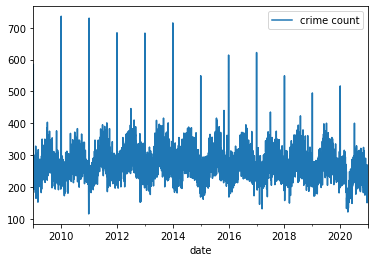

In [5]:
atl_v.plot()

In [6]:
atl_temp

,avgTemp
date,
2009-01-01,37.94
2009-01-02,43.52
2009-01-03,51.98
2009-01-04,59.45
2009-01-05,62.42
...,...
2020-12-27,43.52
2020-12-28,47.03
2020-12-29,52.52


,avgTemp
date,
2009-01-01,37.94
2009-01-02,43.52
2009-01-03,51.98
2009-01-04,59.45
2009-01-05,62.42
...,...
2020-12-27,43.52
2020-12-28,47.03
2020-12-29,52.52


In [7]:
len(atl_temp)

4383

4383

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

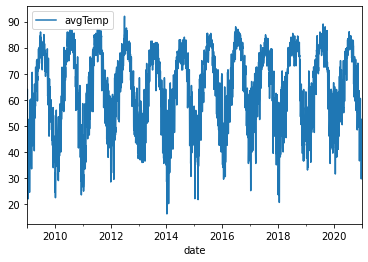

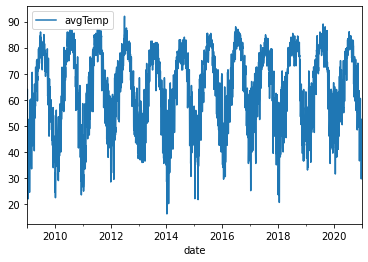

In [8]:
atl_temp.plot()

In [9]:
holiday

,Holiday
date,
2009-01-01,1
2009-01-02,0
2009-01-03,0
2009-01-04,0
2009-01-05,0
...,...
2020-12-27,0
2020-12-28,0
2020-12-29,0


,Holiday
date,
2009-01-01,1
2009-01-02,0
2009-01-03,0
2009-01-04,0
2009-01-05,0
...,...
2020-12-27,0
2020-12-28,0
2020-12-29,0


In [10]:
exo_temp_hol = pd.merge(atl_temp, holiday, left_index=True, right_index=True)

In [11]:
exo_temp_hol

,avgTemp,Holiday
date,,
2009-01-01,37.94,1
2009-01-02,43.52,0
2009-01-03,51.98,0
2009-01-04,59.45,0
2009-01-05,62.42,0
...,...,...
2020-12-27,43.52,0
2020-12-28,47.03,0
2020-12-29,52.52,0


,avgTemp,Holiday
date,,
2009-01-01,37.94,1
2009-01-02,43.52,0
2009-01-03,51.98,0
2009-01-04,59.45,0
2009-01-05,62.42,0
...,...,...
2020-12-27,43.52,0
2020-12-28,47.03,0
2020-12-29,52.52,0


In [12]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=7*4, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))

In [13]:
test_stationarity(atl_v)

Results of Dickey-Fuller Test:
Test Statistic                   -4.165
p-value                           0.001
#Lags Used                       28.000
Number of Observations Used    4354.000
Critical Value (1%)              -3.432
Critical Value (5%)              -2.862
Critical Value (10%)             -2.567
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   -4.165
p-value                           0.001
#Lags Used                       28.000
Number of Observations Used    4354.000
Critical Value (1%)              -3.432
Critical Value (5%)              -2.862
Critical Value (10%)             -2.567
dtype: float64


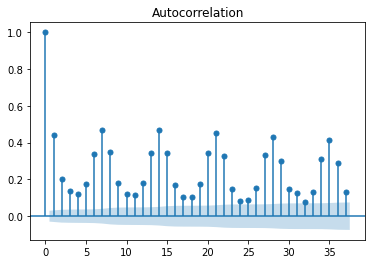

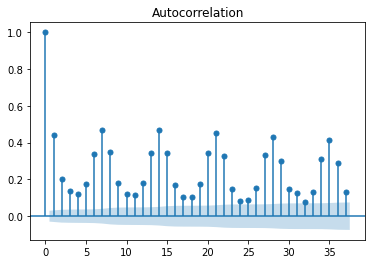

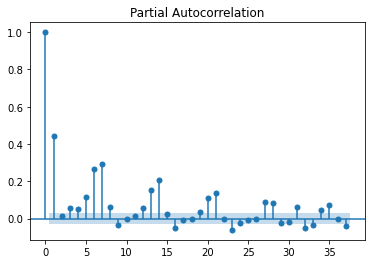

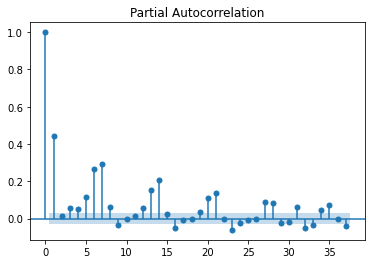

In [14]:
acf=plot_acf(atl_v)
pacf=plot_pacf(atl_v)

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

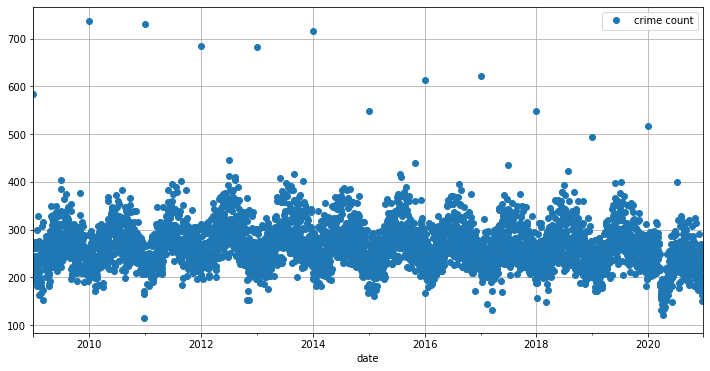

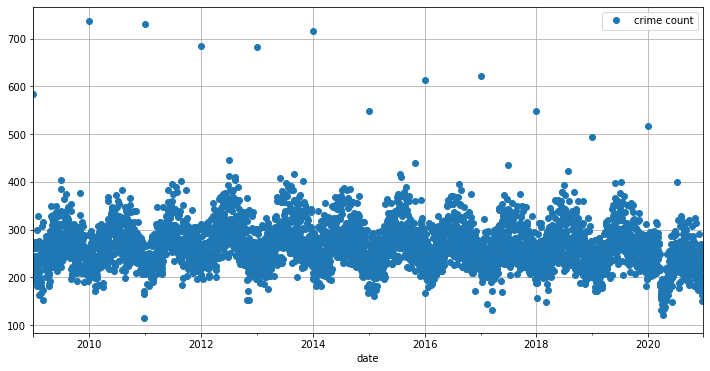

In [15]:
train_end = '2020-12-24'
#test_start = '2020-12-18'
test_end = '2020-12-31'
demo_start = '2020-10-31'
demo = atl_v[demo_start:test_end]
atl_v_train, atl_v_test = atl_v[:train_end], atl_v[train_end:]

atl_v_train.plot(figsize=(12,6), style='o', grid=True)

In [16]:
begin = '2009-01-01'
abv = '2020-12-30'

exo = holiday.copy()
exo_train,exo_test = exo[:train_end], exo[train_end:abv]
exo_test

,Holiday
date,
2020-12-24,1
2020-12-25,1
2020-12-26,0
2020-12-27,0
2020-12-28,0
2020-12-29,0
2020-12-30,0


,Holiday
date,
2020-12-24,1
2020-12-25,1
2020-12-26,0
2020-12-27,0
2020-12-28,0
2020-12-29,0
2020-12-30,0


In [17]:
exo2 = atl_temp.copy()
exo2_train,exo2_test = exo2[:train_end], exo2[train_end:abv]
exo2_test

,avgTemp
date,
2020-12-24,43.52
2020-12-25,29.66
2020-12-26,35.06
2020-12-27,43.52
2020-12-28,47.03
2020-12-29,52.52
2020-12-30,49.01


,avgTemp
date,
2020-12-24,43.52
2020-12-25,29.66
2020-12-26,35.06
2020-12-27,43.52
2020-12-28,47.03
2020-12-29,52.52
2020-12-30,49.01


In [18]:
exo_temp_hol_train, exo_temp_hol_test = exo_temp_hol[:train_end], exo_temp_hol[train_end:abv]
exo_temp_hol_test

,avgTemp,Holiday
date,,
2020-12-24,43.52,1
2020-12-25,29.66,1
2020-12-26,35.06,0
2020-12-27,43.52,0
2020-12-28,47.03,0
2020-12-29,52.52,0
2020-12-30,49.01,0


,avgTemp,Holiday
date,,
2020-12-24,43.52,1
2020-12-25,29.66,1
2020-12-26,35.06,0
2020-12-27,43.52,0
2020-12-28,47.03,0
2020-12-29,52.52,0
2020-12-30,49.01,0


In [19]:
exo_temp_hol_test.shape

(7, 2)

(7, 2)

In [20]:
exo_temp_hol_train.shape

(4376, 2)

(4376, 2)

In [21]:
exo2_train.shape

(4376, 1)

(4376, 1)

In [22]:
exo2_test.shape

(7, 1)

(7, 1)

In [23]:
exo_train.shape

(4376, 1)

(4376, 1)

In [24]:
exo_test.shape

(7, 1)

(7, 1)

In [25]:
atl_v_train.shape

(4376, 1)

(4376, 1)

In [26]:
atl_v_test.shape

(8, 1)

(8, 1)

In [27]:
def sarimax(ts,exo,all_param):
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(ts,
                          exog = exo,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
        except Exception as e:
            print(e)
            continue
            
    return results

In [28]:
# set parameter range
p,d,q = range(0,2),[1],range(0,2)
P,D,Q,s = range(0,2),[1],range(0,2),[7]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

In [29]:
all_res = sarimax(atl_v_train,exo_temp_hol_train,all_param)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.21362D+00    |proj g|=  2.45184D-04


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.21362D+00    |proj g|=  2.45184D-04

At iterate    5    f=  5.52923D+00    |proj g|=  4.13392D-04

At iterate    5    f=  5.52923D+00    |proj g|=  4.13392D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     26      1     0     0   3.387D-07   5.529D+00
  F =   5.5292243040108833     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 7) - AIC:48397.77
           * * 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.27236D+00    |proj g|=  5.60995D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.27236D+00    |proj g|=  5.60995D-02

At iterate    5    f=  5.21266D+00    |proj g|=  5.88233D-03

At iterate    5    f=  5.21266D+00    |proj g|=  5.88233D-03

At iterate   10    f=  5.20576D+00    |proj g|=  3.58045D-04

At iterate   10    f=  5.20576D+00    |proj g|=  3.58045D-04

At iterate   15    f=  5.20565D+00    |proj g|=  2.92466D-05

At iterate   15    f=  5.20565D+00    |proj g|=  2.92466D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.38122D+00    |proj g|=  3.74597D-03


 This problem is unconstrained.



At iterate    5    f=  5.38118D+00    |proj g|=  1.63338D-03

At iterate    5    f=  5.38118D+00    |proj g|=  1.63338D-03

At iterate   10    f=  5.38112D+00    |proj g|=  4.94554D-03

At iterate   10    f=  5.38112D+00    |proj g|=  4.94554D-03

At iterate   15    f=  5.38102D+00    |proj g|=  1.37992D-03

At iterate   15    f=  5.38102D+00    |proj g|=  1.37992D-03

At iterate   20    f=  5.38076D+00    |proj g|=  5.48766D-03

At iterate   20    f=  5.38076D+00    |proj g|=  5.48766D-03

At iterate   25    f=  5.38048D+00    |proj g|=  4.13612D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     30   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.22929D+00    |proj g|=  1.12033D-02

At iterate    5    f=  5.22929D+00    |proj g|=  1.12033D-02

At iterate   10    f=  5.20639D+00    |proj g|=  6.63919D-04

At iterate   10    f=  5.20639D+00    |proj g|=  6.63919D-04

At iterate   15    f=  5.20608D+00    |proj g|=  7.93804D-04

At iterate   15    f=  5.20608D+00    |proj g|=  7.93804D-04

At iterate   20    f=  5.20565D+00    |proj g|=  1.51459D-04

At iterate   20    f=  5.20565D+00    |proj g|=  1.51459D-04

At iterate   25    f=  5.20558D+00    |proj g|=  9.23179D-04

At iterate   25    f=  5.20558D+00    |proj g|=  9.23179D-04

At iterate   30    f=  5.20542D+00    |proj g|=  6.17618D-05

At iterate   30    f=  5.20542D+00    |proj g|=  6.17618D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.27072D+00    |proj g|=  4.70228D-03

At iterate    5    f=  5.27072D+00    |proj g|=  4.70228D-03

At iterate   10    f=  5.26118D+00    |proj g|=  6.06741D-04

At iterate   10    f=  5.26118D+00    |proj g|=  6.06741D-04

At iterate   15    f=  5.25751D+00    |proj g|=  2.67344D-04

At iterate   15    f=  5.25751D+00    |proj g|=  2.67344D-04

At iterate   20    f=  5.25749D+00    |proj g|=  6.86229D-04

At iterate   20    f=  5.25749D+00    |proj g|=  6.86229D-04

At iterate   25    f=  5.25743D+00    |proj g|=  1.68941D-04

At iterate   25    f=  5.25743D+00    |proj g|=  1.68941D-04

At iterate   30    f=  5.25742D+00    |proj g|=  4.45517D-05

At iterate   30    f=  5.25742D+00    |proj g|=  4.45517D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12583D+00    |proj g|=  5.23947D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12583D+00    |proj g|=  5.23947D-02

At iterate    5    f=  5.00514D+00    |proj g|=  4.63146D-02

At iterate    5    f=  5.00514D+00    |proj g|=  4.63146D-02

At iterate   10    f=  4.96643D+00    |proj g|=  9.92201D-03

At iterate   10    f=  4.96643D+00    |proj g|=  9.92201D-03

At iterate   15    f=  4.95558D+00    |proj g|=  6.86450D-04

At iterate   15    f=  4.95558D+00    |proj g|=  6.86450D-04

At iterate   20    f=  4.94833D+00    |proj g|=  1.91272D-03

At iterate   20    f=  4.94833D+00    |proj g|=  1.91272D-03

At iterate   25    f=  4.94818D+00    |proj g

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.15212D+00    |proj g|=  6.42358D-03

At iterate    5    f=  5.15212D+00    |proj g|=  6.42358D-03

At iterate   10    f=  5.11353D+00    |proj g|=  6.41979D-04

At iterate   10    f=  5.11353D+00    |proj g|=  6.41979D-04

At iterate   15    f=  5.10825D+00    |proj g|=  3.96131D-03

At iterate   15    f=  5.10825D+00    |proj g|=  3.96131D-03

At iterate   20    f=  5.10704D+00    |proj g|=  7.21383D-05

At iterate   20    f=  5.10704D+00    |proj g|=  7.21383D-05

At iterate   25    f=  5.10699D+00    |proj g|=  1.28378D-03

At iterate   25    f=  5.10699D+00    |proj g|=  1.28378D-03

At iterate   30    f=  5.10687D+00    |proj g|=  6.72707D-04

At iterate   30    f=  5.10687D+00    |proj g|=  6.72707D-04

At iterate   35    f=  5.10686D+00    |proj g|=  2.34655D-04

At iterate   35    f=  5.10686D+00    |proj g|=  2.34655D-04

At iterate   40    f=  5.10685D+00    |proj g|=  1.21771D-04

At iterate   40    f=  5.10685D+00    |proj g|=  1.21771D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.05875D+00    |proj g|=  1.00745D-02

At iterate    5    f=  5.05875D+00    |proj g|=  1.00745D-02

At iterate   10    f=  4.97577D+00    |proj g|=  8.35753D-03

At iterate   10    f=  4.97577D+00    |proj g|=  8.35753D-03

At iterate   15    f=  4.95630D+00    |proj g|=  2.12187D-02

At iterate   15    f=  4.95630D+00    |proj g|=  2.12187D-02

At iterate   20    f=  4.95563D+00    |proj g|=  6.93742D-04

At iterate   20    f=  4.95563D+00    |proj g|=  6.93742D-04

At iterate   25    f=  4.95344D+00    |proj g|=  1.99012D-02

At iterate   25    f=  4.95344D+00    |proj g|=  1.99012D-02

At iterate   30    f=  4.94863D+00    |proj g|=  3.22540D-03

At iterate   30    f=  4.94863D+00    |proj g|=  3.22540D-03

At iterate   35    f=  4.94822D+00    |proj g|=  1.63233D-04

At iterate   35    f=  4.94822D+00    |proj g|=  1.63233D-04

At iterate   40    f=  4.94819D+00    |proj g|=  5.71935D-04

At iterate   40    f=  4.94819D+00    |proj g|=  5.71935D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.42329D+00    |proj g|=  2.82212D-03

At iterate    5    f=  5.42329D+00    |proj g|=  2.82212D-03

At iterate   10    f=  5.42325D+00    |proj g|=  4.88441D-03

At iterate   10    f=  5.42325D+00    |proj g|=  4.88441D-03

At iterate   15    f=  5.42283D+00    |proj g|=  3.26697D-03

At iterate   15    f=  5.42283D+00    |proj g|=  3.26697D-03

At iterate   20    f=  5.42266D+00    |proj g|=  5.92042D-03

At iterate   20    f=  5.42266D+00    |proj g|=  5.92042D-03

At iterate   25    f=  5.42161D+00    |proj g|=  4.67157D-03

At iterate   25    f=  5.42161D+00    |proj g|=  4.67157D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.21043D+00    |proj g|=  4.12162D-02


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.21043D+00    |proj g|=  4.12162D-02

At iterate    5    f=  5.16319D+00    |proj g|=  7.82513D-03

At iterate    5    f=  5.16319D+00    |proj g|=  7.82513D-03

At iterate   10    f=  5.10537D+00    |proj g|=  6.63292D-04

At iterate   10    f=  5.10537D+00    |proj g|=  6.63292D-04

At iterate   15    f=  5.10163D+00    |proj g|=  3.98047D-03

At iterate   15    f=  5.10163D+00    |proj g|=  3.98047D-03

At iterate   20    f=  5.09832D+00    |proj g|=  1.73200D-04

At iterate   20    f=  5.09832D+00    |proj g|=  1.73200D-04

At iterate   25    f=  5.09791D+00    |proj g|=  3.79552D-03

At iterate   25    f=  5.09791D+00    |proj g|=  3.79552D-03

At iterate   30    f=  5.09731D+00    |proj g|=  7.23555D-05

At iterate   30    f=  5.09731D+00    |proj g|=  7.23555D-05

At iterate   35    f=  5.0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.28758D+00    |proj g|=  5.01117D-02

At iterate    5    f=  5.28758D+00    |proj g|=  5.01117D-02

At iterate   10    f=  5.27426D+00    |proj g|=  1.30648D-02

At iterate   10    f=  5.27426D+00    |proj g|=  1.30648D-02

At iterate   15    f=  5.27247D+00    |proj g|=  7.33680D-04

At iterate   15    f=  5.27247D+00    |proj g|=  7.33680D-04

At iterate   20    f=  5.27104D+00    |proj g|=  2.18774D-02

At iterate   20    f=  5.27104D+00    |proj g|=  2.18774D-02

At iterate   25    f=  5.26712D+00    |proj g|=  4.95245D-04

At iterate   25    f=  5.26712D+00    |proj g|=  4.95245D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.18300D+00    |proj g|=  3.07734D-02

At iterate    5    f=  5.18300D+00    |proj g|=  3.07734D-02

At iterate   10    f=  5.10525D+00    |proj g|=  1.29329D-02

At iterate   10    f=  5.10525D+00    |proj g|=  1.29329D-02

At iterate   15    f=  5.10489D+00    |proj g|=  2.49477D-03

At iterate   15    f=  5.10489D+00    |proj g|=  2.49477D-03

At iterate   20    f=  5.10309D+00    |proj g|=  3.14216D-02

At iterate   20    f=  5.10309D+00    |proj g|=  3.14216D-02

At iterate   25    f=  5.09864D+00    |proj g|=  1.13786D-03

At iterate   25    f=  5.09864D+00    |proj g|=  1.13786D-03

At iterate   30    f=  5.09862D+00    |proj g|=  1.55294D-04

At iterate   30    f=  5.09862D+00    |proj g|=  1.55294D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.27071D+00    |proj g|=  1.29288D-02

At iterate    5    f=  5.27071D+00    |proj g|=  1.29288D-02

At iterate   10    f=  5.25388D+00    |proj g|=  5.55711D-03

At iterate   10    f=  5.25388D+00    |proj g|=  5.55711D-03

At iterate   15    f=  5.25035D+00    |proj g|=  3.15459D-02

At iterate   15    f=  5.25035D+00    |proj g|=  3.15459D-02

At iterate   20    f=  5.24934D+00    |proj g|=  4.45348D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   1.395D-05   5.249D+00
  F =   5.2493380975447677     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.05249D+00    |proj g|=  1.02321D-02

At iterate    5    f=  5.05249D+00    |proj g|=  1.02321D-02

At iterate   10    f=  4.96400D+00    |proj g|=  1.94000D-03

At iterate   10    f=  4.96400D+00    |proj g|=  1.94000D-03

At iterate   15    f=  4.95068D+00    |proj g|=  2.09732D-02

At iterate   15    f=  4.95068D+00    |proj g|=  2.09732D-02

At iterate   20    f=  4.94931D+00    |proj g|=  1.24211D-03

At iterate   20    f=  4.94931D+00    |proj g|=  1.24211D-03

At iterate   25    f=  4.94741D+00    |proj g|=  1.68735D-02

At iterate   25    f=  4.94741D+00    |proj g|=  1.68735D-02

At iterate   30    f=  4.94382D+00    |proj g|=  2.63848D-03

At iterate   30    f=  4.94382D+00    |proj g|=  2.63848D-03

At iterate   35    f=  4.94373D+00    |proj g|=  4.93261D-03

At iterate   35    f=  4.94373D+00    |proj g|=  4.93261D-03

At iterate   40    f=  4.94349D+00    |proj g|=  3.71100D-03

At iterate   40    f=  4.94349D+00    |proj g|=  3.71100D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.16070D+00    |proj g|=  3.85406D-02

At iterate    5    f=  5.16070D+00    |proj g|=  3.85406D-02

At iterate   10    f=  5.10591D+00    |proj g|=  3.07245D-02

At iterate   10    f=  5.10591D+00    |proj g|=  3.07245D-02

At iterate   15    f=  5.10392D+00    |proj g|=  5.46111D-04

At iterate   15    f=  5.10392D+00    |proj g|=  5.46111D-04

At iterate   20    f=  5.10384D+00    |proj g|=  6.23378D-03

At iterate   20    f=  5.10384D+00    |proj g|=  6.23378D-03

At iterate   25    f=  5.10034D+00    |proj g|=  3.10470D-02

At iterate   25    f=  5.10034D+00    |proj g|=  3.10470D-02

At iterate   30    f=  5.09940D+00    |proj g|=  4.20378D-04

At iterate   30    f=  5.09940D+00    |proj g|=  4.20378D-04

At iterate   35    f=  5.09939D+00    |proj g|=  1.04746D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.07659D+00    |proj g|=  2.75212D-02

At iterate    5    f=  5.07659D+00    |proj g|=  2.75212D-02

At iterate   10    f=  4.98138D+00    |proj g|=  7.60164D-02

At iterate   10    f=  4.98138D+00    |proj g|=  7.60164D-02

At iterate   15    f=  4.96537D+00    |proj g|=  3.18941D-02

At iterate   15    f=  4.96537D+00    |proj g|=  3.18941D-02

At iterate   20    f=  4.94925D+00    |proj g|=  7.35850D-03

At iterate   20    f=  4.94925D+00    |proj g|=  7.35850D-03

At iterate   25    f=  4.94904D+00    |proj g|=  2.82418D-03

At iterate   25    f=  4.94904D+00    |proj g|=  2.82418D-03

At iterate   30    f=  4.94463D+00    |proj g|=  1.40568D-02

At iterate   30    f=  4.94463D+00    |proj g|=  1.40568D-02

At iterate   35    f=  4.94365D+00    |proj g|=  3.23661D-04

At iterate   35    f=  4.94365D+00    |proj g|=  3.23661D-04

At iterate   40    f=  4.94348D+00    |proj g|=  2.56381D-03

At iterate   40    f=  4.94348D+00    |proj g|=  2.56381D-03

At iter

In [30]:
all_res.sort(key=lambda x: x[1])
all_res[:5]

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fe024f68970>,
  43277.38730908334,
  ((1, 1, 1), (0, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fe0142ed070>,
  43278.918426847405,
  ((1, 1, 1), (1, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fe06e4f8070>,
  43316.44598903891,
  ((0, 1, 1), (0, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fe04b131f10>,
  43318.3760162296,
  ((0, 1, 1), (1, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fe040a26340>,
  44621.645549902794,
  ((1, 1, 0), (0, 1, 1, 7)))]

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fe024f68970>,
  43277.38730908334,
  ((1, 1, 1), (0, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fe0142ed070>,
  43278.918426847405,
  ((1, 1, 1), (1, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fe06e4f8070>,
  43316.44598903891,
  ((0, 1, 1), (0, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fe04b131f10>,
  43318.3760162296,
  ((0, 1, 1), (1, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fe040a26340>,
  44621.645549902794,
  ((1, 1, 0), (0, 1, 1, 7)))]

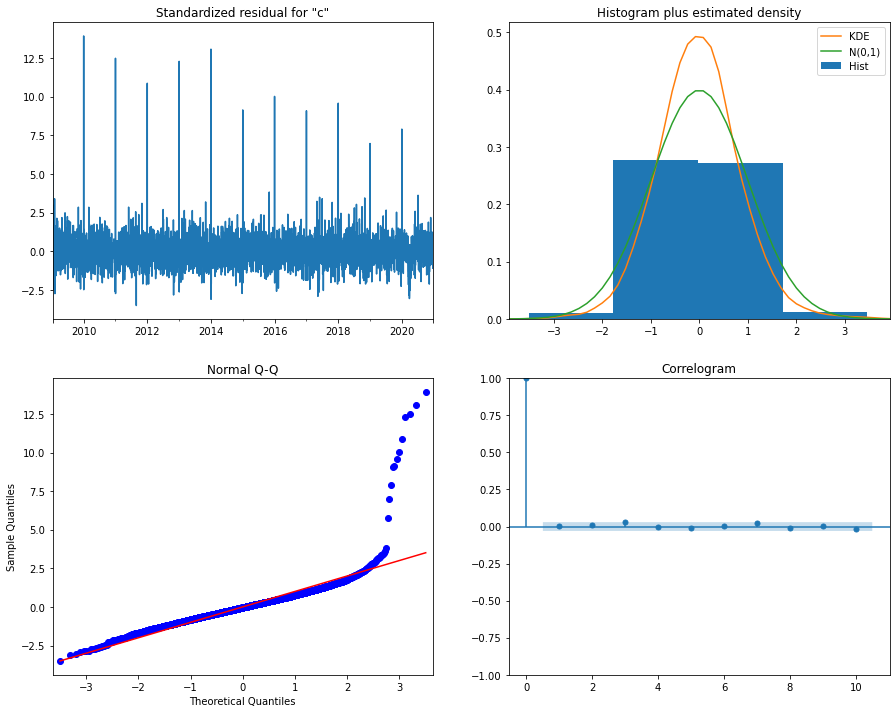

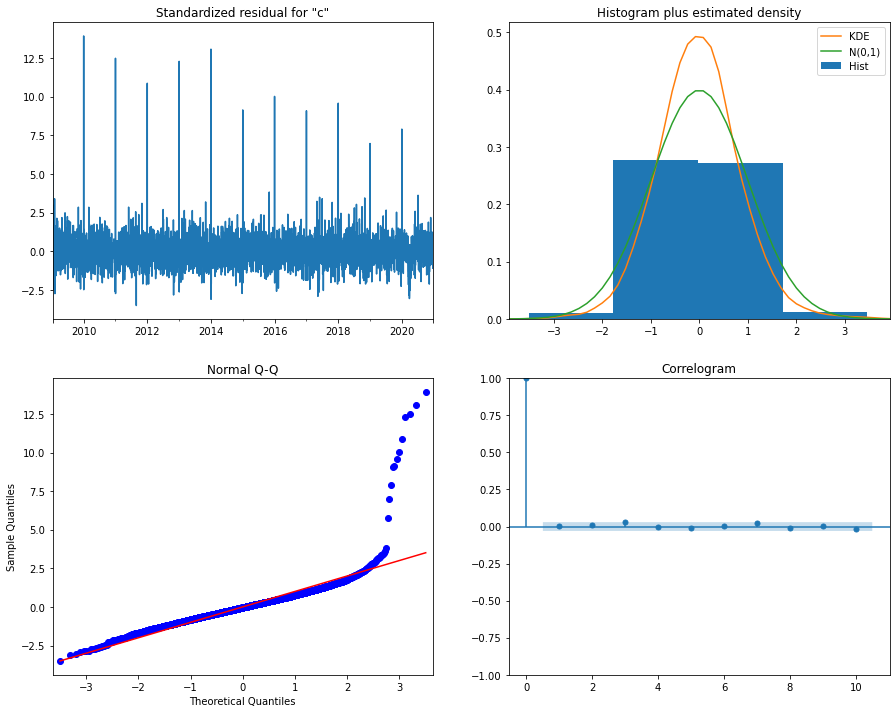

Ljung-box p-values:
[0.68554233 0.76781481 0.27388252 0.4214264  0.49560732 0.6139257
 0.39762574 0.45999621 0.55227498 0.55792522 0.56364373 0.64528979
 0.69551652 0.02776745]
Ljung-box p-values:
[0.68554233 0.76781481 0.27388252 0.4214264  0.49560732 0.6139257
 0.39762574 0.45999621 0.55227498 0.55792522 0.56364373 0.64528979
 0.69551652 0.02776745]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       crime count   No. Observations:                 4376
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood              -21632.694
Date:                           Tue, 26 Apr 2022   AIC                          43277.387
Time:                                   22:19:01   BIC                          43315.680
Sample:                               01-01-2009   HQIC                         43290.900
                                    - 12-24-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
avgTemp        1.1617      0.066     17.728      0.000       1.033       1.290
Holiday       36.9962      1.965     18.827      0.000      33.145      40.848
ar.L1          0.1066      0.011      9.350      0.000       0.084       0.129
ma.L1         -0.9497      0.005   -197.068      0.000      -0.959      -0.940
ma.S.L7       -0.9915      0.003   -378.238      0.000      -0.997      -0.986
sigma2      1164.1687     10.357    112.409      0.000    1143.870    1184.467
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):            260724.75
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             3.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       crime count   No. Observations:                 4376
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood              -21632.694
Date:                           Tue, 26 Apr 2022   AIC                          43277.387
Time:                                   22:19:01   BIC                          43315.680
Sample:                               01-01-2009   HQIC                         43290.900
                                    - 12-24-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
avgTemp        1.1617      0.066     17.728      0.000       1.033       1.290
Holiday       36.9962      1.965     18.827      0.000      33.145      40.848
ar.L1          0.1066      0.011      9.350      0.000       0.084       0.129
ma.L1         -0.9497      0.005   -197.068      0.000      -0.959      -0.940
ma.S.L7       -0.9915      0.003   -378.238      0.000      -0.997      -0.986
sigma2      1164.1687     10.357    112.409      0.000    1143.870    1184.467
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):            260724.75
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             3.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
res = all_res[0][0]
res.plot_diagnostics(figsize=(15, 12))

plt.show()
print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))
res.summary()

In [32]:
def pm(y_true, y_pred):
    return sum((y_true-y_pred)**2)/sum((y_true-np.mean(y_true))**2)

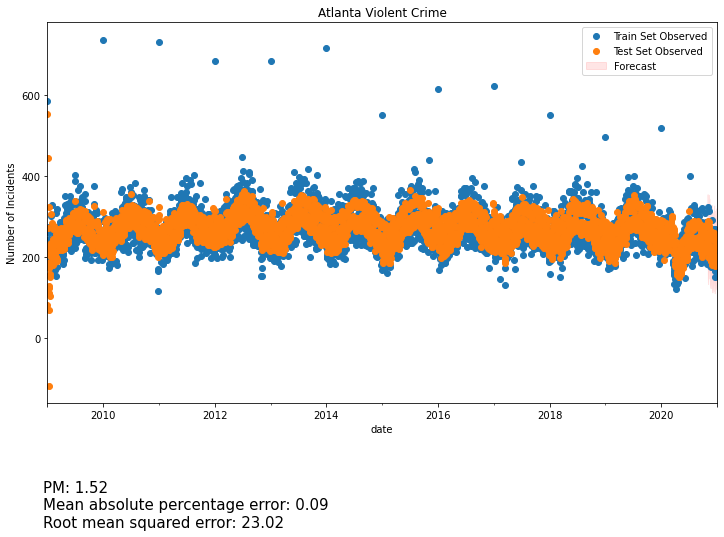

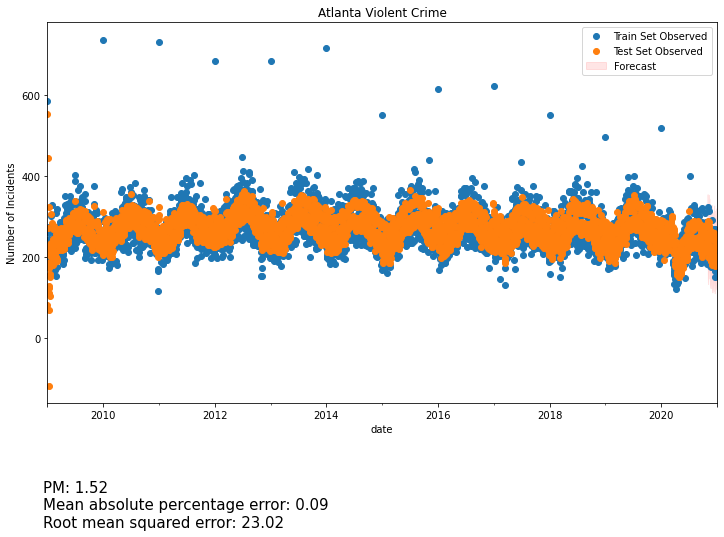

In [33]:
pred_test = res.get_prediction(start=train_end,end=test_end,exog=exo_temp_hol_test)
err = ('\nPM: %.2f'% pm(atl_v_test['crime count'], pred_test.predicted_mean.to_frame()['predicted_mean']) + \
      '\nMean absolute percentage error: %.2f'% MAPE(atl_v_test, pred_test.predicted_mean) + \
      '\nRoot mean squared error: %.2f'% sqrt(MSE(atl_v_test, pred_test.predicted_mean)))

pred = res.get_prediction(start=begin,end=test_end,exog=exo_temp_hol_test)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Atlanta Violent Crime', ylabel='Number of Incidents')

atl_v.plot(ax=ax, style = 'o')
pred.predicted_mean.plot(ax=ax, style='o')
ci = pred_ci.loc[demo_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])



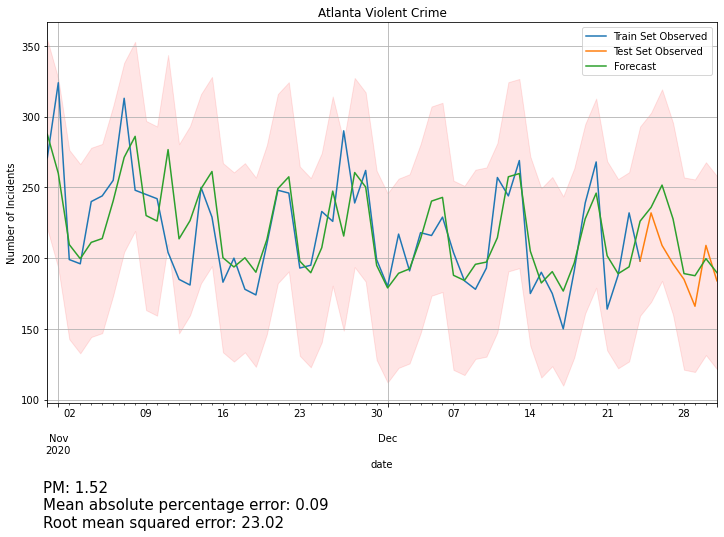

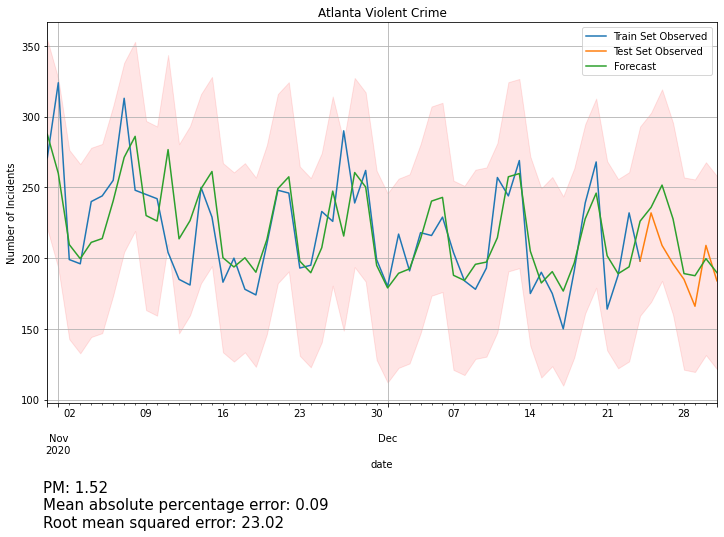

In [34]:
pred_test = res.get_prediction(start=train_end,end=test_end,exog=exo_temp_hol_test)
# The root mean squared error
err = ('\nPM: %.2f'% pm(atl_v_test['crime count'], pred_test.predicted_mean.to_frame()['predicted_mean']) + \
      '\nMean absolute percentage error: %.2f'% MAPE(atl_v_test, pred_test.predicted_mean) + \
      '\nRoot mean squared error: %.2f'% sqrt(MSE(atl_v_test, pred_test.predicted_mean)))

pred = res.get_prediction(start=demo_start,end=test_end,exog=exo_temp_hol_test)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Atlanta Violent Crime', ylabel='Number of Incidents')

atl_v_train[demo_start:].plot(ax=ax)
atl_v_test.plot(ax=ax)
pred.predicted_mean.plot(ax=ax)
ci = pred_ci.loc[demo_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])
ax.grid(True)